Epoch 1 Training Loss = 0.6349333292908139
Epoch 2 Training Loss = 0.42028351845564665
Epoch 3 Training Loss = 0.3046879669030507
Test Accuracy = 0.98
Misclassified Test Indices: [47]


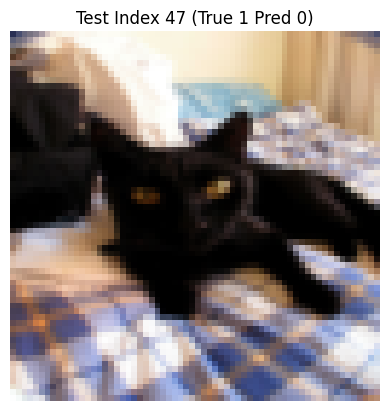

In [ ]:
# Section 5: Binary Image Classification (Original Dataset)
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import h5py
import matplotlib.pyplot as plt

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset class for h5 image files
class H5ImageDataset(Dataset):
    def __init__(self, path, transform=None):
        # load the h5 file contents
        with h5py.File(path, 'r') as hf:
            if "train_set_x" in hf:
                self.X = np.array(hf["train_set_x"])
                self.y = np.array(hf["train_set_y"])
            else:
                self.X = np.array(hf["test_set_x"])
                self.y = np.array(hf["test_set_y"])
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = int(self.y[idx])
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

# file paths (already uploaded)
train_path = "train_catvnoncat.h5"
test_path = "test_catvnoncat.h5"

# preprocessing pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_dataset = H5ImageDataset(train_path, transform)
test_dataset = H5ImageDataset(test_path, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# load pretrained resnet18 and replace final layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# train for a few epochs
epochs = 3
model.train()
for e in range(epochs):
    losses = []
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {e+1} Training Loss =", np.mean(losses))

# evaluate
model.eval()
preds = []
true = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        p = torch.sigmoid(out).cpu().numpy().flatten()
        preds.extend((p > 0.5).astype(int))
        true.extend(labels.numpy().astype(int))

preds = np.array(preds)
true = np.array(true)

acc = np.mean(preds == true)
print("Test Accuracy =", acc)

mis = np.where(preds != true)[0]
print("Misclassified Test Indices:", mis.tolist())

# show up to 4 misclassified samples
for i in range(min(4, len(mis))):
    idx = mis[i]
    img = test_dataset.X[idx]
    plt.imshow(img.astype(np.uint8))
    plt.title(f"Test Index {idx} (True {true[idx]} Pred {preds[idx]})")
    plt.axis("off")
    plt.show()